In [1]:
import sys
sys.path.append('..')
sys.path.append('../external_libs/WavLM')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from pathlib import Path
import torchaudio
import fairseq
import torch
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [4]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [5]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [6]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

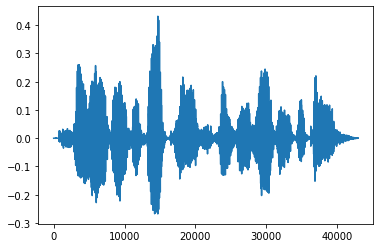

In [7]:
plt.plot(wav.numpy().ravel())

In [8]:
from WavLM import WavLM, WavLMConfig

checkpoint = torch.load('../external_libs/WavLM/WavLM-Base.pt')
cfg = WavLMConfig(checkpoint['cfg'])
model = WavLM(cfg)
model.load_state_dict(checkpoint['model'])



2022-02-06 02:59:00 | INFO | WavLM | WavLM Config: {'extractor_mode': 'default', 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': 'gelu', 'layer_norm_first': False, 'conv_feature_layers': '[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2', 'conv_bias': False, 'feature_grad_mult': 0.1, 'normalize': False, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1, 'mask_length': 10, 'mask_prob': 0.8, 'mask_selection': 'static', 'mask_other': 0.0, 'no_mask_overlap': False, 'mask_min_space': 1, 'mask_channel_length': 10, 'mask_channel_prob': 0.0, 'mask_channel_selection': 'static', 'mask_channel_other': 0.0, 'no_mask_channel_overlap': False, 'mask_channel_min_space': 1, 'conv_pos': 128, 'conv_pos_groups': 16, 'relative_position_embedding': True, 'num_buckets': 320, 'max_distance': 800, 'gru_rel_pos': True, 'expand_attention_head_s

<All keys matched successfully>

In [9]:
model.to(device)
model.eval();

In [10]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [11]:
res = model.extract_features(wav.to(device))
res

(tensor([[[-0.0609,  0.0539, -0.3479,  ...,  0.9963,  0.5308, -0.5962],
          [ 0.0633, -0.0272, -0.3262,  ...,  0.4240,  0.4274, -0.2469],
          [-0.0815, -0.0953, -0.3420,  ...,  0.9306, -0.1726, -0.5543],
          ...,
          [-0.1105,  0.0162, -0.0605,  ...,  0.0885, -0.3970, -0.0778],
          [-0.2606,  0.2703, -0.0290,  ...,  0.3602, -0.1127, -0.6138],
          [-0.3437,  0.1784, -0.0435,  ...,  0.7551,  0.1699, -0.3949]]],
        device='cuda:0', grad_fn=<TransposeBackward0>),
 None)

In [12]:
res[0].size()

torch.Size([1, 133, 768])

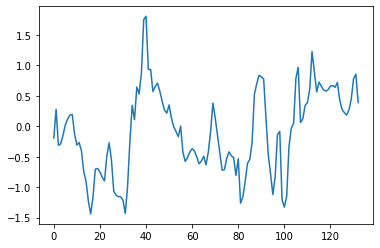

In [13]:
plt.plot(res[0].squeeze(0)[:, 350].detach().cpu().numpy())

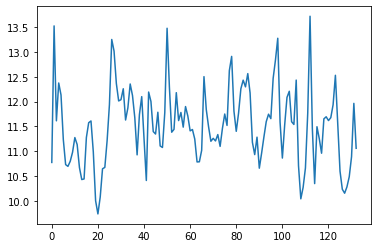

In [14]:
plt.plot(torch.linalg.vector_norm(res[0].squeeze(0), dim=1).detach().cpu().numpy())

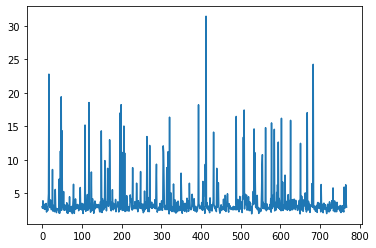

In [15]:
plt.plot(torch.linalg.vector_norm(res[0].squeeze(0), dim=0).detach().cpu().numpy())

In [16]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = model.extract_features(wav.to(device))
        return res[0].squeeze(0).mean(dim=0)


In [17]:
extract_mean(wavpath).size()

torch.Size([768])

In [18]:
out_dir = Path('../out/utt_data/wavlm_base')
import os
os.makedirs(out_dir, exist_ok=True)


In [19]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [20]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [21]:
train_X = np.array(train_vecs)
train_y = np.array(train_moss)
val_X = np.array(val_vecs)
val_y = np.array(val_moss)
train_X.shape

(4974, 768)

In [22]:
uttemb_dir = Path('../out/utt_emb/wavlm_base')
os.makedirs(uttemb_dir, exist_ok=True)
np.save(uttemb_dir / 'train_X.npy', train_X)
np.save(uttemb_dir / 'train_y.npy', train_y)
np.save(uttemb_dir / 'val_X.npy', val_X)
np.save(uttemb_dir / 'val_y.npy', val_y)